# Using Astropy and Gaia DR3 to make an H-R diagram

Make an observed Hertzsprung-Russell diagram for Gaia DR3 stars within 100pc of the Sun with <1% parallax
precision and apparent G >18 magnitude. This selects ~200k stars.

Uses `astroquery` to retrieve the data from the Gaia DR3 database. With a fast (>500Mbps) ethernet connection
and normal Gaia server load, the query to retrieve ~200k stars takes 20 to 60 seconds.

In [13]:
%matplotlib inline

import numpy as np

import time

# astropy modules

import astropy.units as u
from astropy.io import votable
from astropy.coordinates import SkyCoord, CartesianRepresentation, SphericalRepresentation, matrix_utilities
from astropy.table import Table

# matplotlib for plotting and visualization

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, NullFormatter

# astroquery for the Gaia database queries

from astroquery import gaia
from astroquery.gaia import Gaia as g
from astroquery.utils.tap import TapPlus

# suppress nuisance warnings

import warnings
warnings.filterwarnings('ignore',category=UserWarning, append=True)
warnings.filterwarnings('ignore',category=RuntimeWarning, append=True)

# some basic setup

g.ROW_LIMIT = -1

using_ari = False

# uncomment these lines to switch to using ARI
#
# orig_gaia = g
# arigaia = gaia.GaiaClass(TapPlus('http://gaia.ari.uni-heidelberg.de/tap'))
# g = arigaia
# using_ari = True

# If using the ARI implementation, this fixes an issue with column identifications
# (don't use ARI if you don't have to).

def fix_ari_query(job):
    from urllib.request import urlopen
    from xml import etree

    remtree = etree.ElementTree.parse(urlopen(job.get_remote_location()))

    res_elem = remtree.find('*/{http://www.ivoa.net/xml/UWS/v1.0}result')
    res_url = res_elem.attrib['{http://www.w3.org/1999/xlink}href']
    res_url

    vtab = votable.parse(res_url)

    for fi in vtab.iter_fields_and_params():
        if not isinstance(fi, votable.tree.Field):
            continue #params
        fi.ID = fi.name
    return vtab.get_first_table().to_table()

## Plot setup

In [14]:
figName = 'HR_GaiaDR3' 

aspect = 3./4. # portrait mode, 4x3 aspect ratio

#
# Don't change these unless you really need to (we never have)
#
# fPage is the horizontal fraction of the page occupied by the figure, default 1.0
#
# scaleFac is the LaTeX includegraphics scaling in units of \textwidth, default 1.0
#

fPage = 1.0
scaleFac = 0.85

# Text width in inches - don't change, this is defined by the print layout

textWidth = 6.0 # inches

# Graphic dimensions depending on bitmap or vector format (draft vs production)

figFmt = 'png'
dpi = 600
plotWidth = dpi*fPage*textWidth
plotHeight = plotWidth/aspect
axisFontSize = 10
labelFontSize = 8
lwidth = 0.5
axisPad = 5
wInches = fPage*textWidth # float(plotWidth)/float(dpi)
hInches = wInches/aspect  # float(plotHeight)/float(dpi)
      
axisFontSize = np.rint(axisFontSize/scaleFac)
labelFontSize = np.rint(labelFontSize/scaleFac)

# Plot filename

plotFile = f'{figName}.{figFmt}'

# LaTeX is used throughout for markup of symbols, Times-Roman serif font

plt.rc('text', usetex=True)
plt.rc('font', **{'family':'serif','serif':['Times-Roman'],'weight':'bold','size':'12'})

# Font and line weight defaults for axes

matplotlib.rc('axes',linewidth=lwidth)
matplotlib.rcParams.update({'font.size':axisFontSize})

# axis and label padding

plt.rcParams['xtick.major.pad']=f'{axisPad}'
plt.rcParams['ytick.major.pad']=f'{axisPad}'
plt.rcParams['axes.labelpad'] = f'{axisPad}'

## Data for nearby stars from Gaia DR3

Gaia DR3 query for nearby stars as follows:
 * stars within 100pc ($\varpi\ge$ 10 mas)
 * parallax uncertainty <1% ($\varpi/\sigma_\varpi\ge$ 100)
 * apparent magnitude $m_G$<18
 * BP and RP fluxes with SNR>10 ($F_x/\sigma_{F_x}\ge$10)
 * proper motions with SNR>10 ($|\mu_x/\sigma_{\mu_x}|\ge$10)
 * Renormalised Unit Weight Error (RUWE) < 1.4

This query returns about 200k stars and takes ~15-60 seconds depending on the server load and your
internet speed.  We time the query and report how many stars we retrieved.

The query returns 4 columns of data:
 * `color` = BP$-$RP color index
 * `mg` = absolute G magnitude (M$_G$) computed using the apparent mean G magnitude and parallax
 * `parallax` $\varpi$ in mas
 * `parallax_error` $\sigma_\varpi$ in mas

We do an additional cut, following Torres et al. 2022, that removes parallaxes within 3$\sigma$ of our
100pc cutoff: $\varpi - 3*\sigma_\varpi \ge 10$

In [15]:
pErr = 100.0 # p/sigma_p = 100 is sigma_p/p=0.01
pMin = 10.0 # nearby stars, parallax > 10 mas
mG_faint = 18.0 # brighter than 18 mag
fxSNR = 10.0 # flux signal to noise threshold
pmSNR = 10.0 # proper motion signal-to-noise threshold

qry=f"""
SELECT phot_bp_mean_mag-phot_rp_mean_mag AS color, phot_g_mean_mag+5*log10(parallax)-10 AS mg, parallax, parallax_error FROM gaiadr3.gaia_source
WHERE parallax_over_error >= {pErr}
AND parallax >= {pMin}
AND phot_g_mean_mag < {mG_faint}
AND phot_bp_mean_flux_over_error >= {fxSNR}
AND phot_rp_mean_flux_over_error >= {fxSNR}
AND abs(pmra/pmra_error) >= {pmSNR}
AND abs(pmdec/pmdec_error) >= {pmSNR}
AND ruwe < 1.4
"""

print('Launching Gaia DR3 query...')

t0 = time.time()
job = g.launch_job_async(qry)
tab = job.get_results()
dt = time.time() - t0

print(f'Retrieved {len(tab)} stars (query took {dt:.1f} seconds)')
# print(tab.columns)

# only need to do the fix described above if the ARI mirror is used

if using_ari:
    tab = fix_ari_query(job)

Launching Gaia DR3 query...
INFO: Query finished. [astroquery.utils.tap.core]
Retrieved 203523 stars (query took 26.9 seconds)


## Extract data and apply additional filtering

Apply a filter on parallax of 
 > $\varpi-3\sigma_\varpi\ge 10$
 
which accounts for 3$\sigma fluctuations of more distant stars than 100pc into the 100pc selection.  This removes 
about 5900 stars, cleaning up the H-R diagram for stars within 100pc except for a small number of unresolved
binaries in the gap between the main sequence and the white dwarf cooling sequence.

This filter is the same as used by Torres et al. 2022, MNRAS, 511, 5462 for their study of white dwarf binaries
within 100pc using Gaia EDR3.

In [16]:
MG = np.array(tab['mg'])
BP_RP = np.array(tab['color'])
w = np.array(tab['parallax'])
w_err = np.array(tab['parallax_error'])

# additional filter for all stars with parallax -3*sigma_parallax >= 10

iFilt = np.where(w-3*w_err >= 10)[0]

dN = len(tab)-len(iFilt)
print(f'Full Sample: {len(tab)} stars, parallax cut {len(iFilt)} stars, removing {dN} stars')

# approximate Red Giant Branch box

rgbBoxX = [0.9 ,0.9,1.7,1.7, 0.9]
rgbBoxY = [-1.5,4.0,4.0,-1.5,-1.5]

# approximate white dwarf sequence box

wdBoxX = [-0.6,1.8 ,1.8,-0.5,-0.6,-0.6]
wdBoxY = [16.0,16.0,14.5,7.5,7.5 ,16.0]

Full Sample: 203523 stars, parallax cut 197582 stars, removing 5941 stars


## Make a plot

The Gaia DR3 query returned the absolute magnitude and BP_RP color letting the Gaia server do that
calculation.

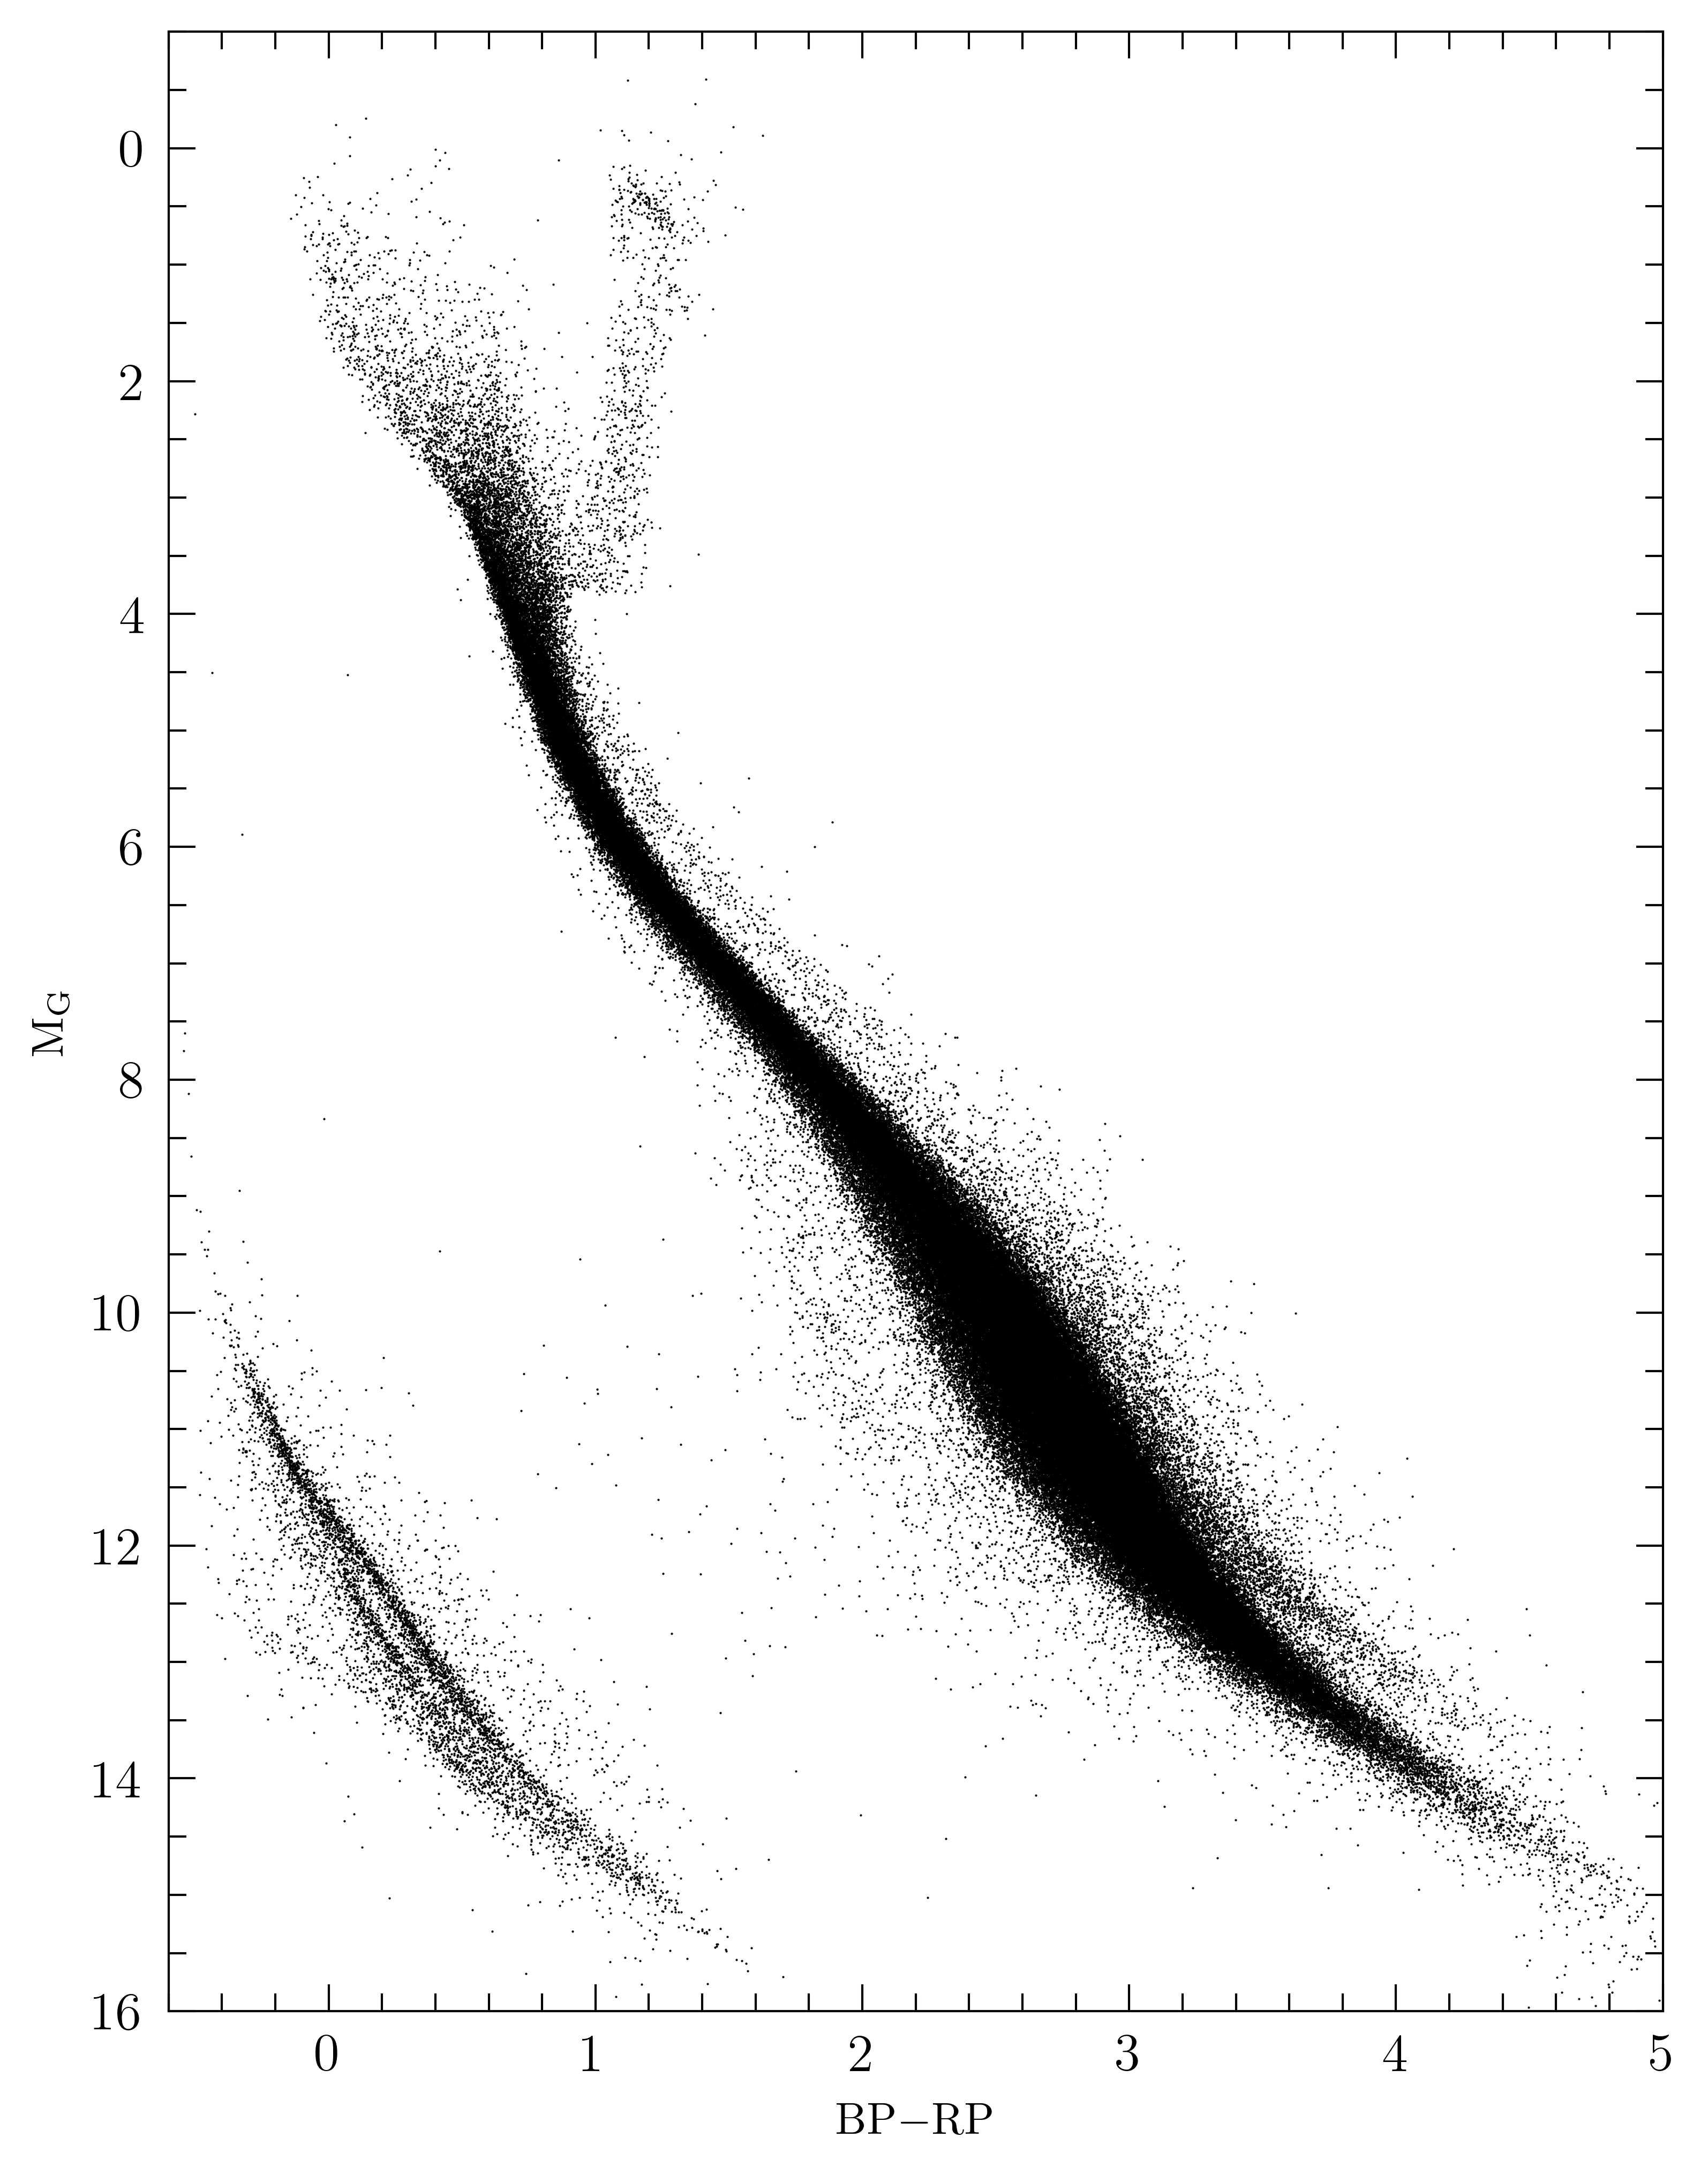

In [17]:
# make the plot

fig,ax = plt.subplots(1,1,figsize=(wInches,hInches),dpi=dpi)
    
ax.set_xlim(-0.6,5.0) # 4.6)
ax.set_ylim(16,-1)
ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top='on',right='on')
ax.tick_params('both',length=4,width=lwidth,which='minor',direction='in',top='on',right='on')
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.set_xlabel(r'BP$-$RP', fontsize=10)
ax.yaxis.set_major_locator(MultipleLocator(2.0))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.set_ylabel(r'M$_{\rm G}$',fontsize=10)

ax.plot(BP_RP[iFilt],MG[iFilt],'o',color='black',ms=0.5,mew=0,alpha=1,zorder=10)

#ax.plot(rgbBoxX,rgbBoxY,':',color='#bb0000',lw=0.5,zorder=9)
#ax.plot(wdBoxX,wdBoxY,':',color='blue',lw=0.5,zorder=9)

plt.plot()
plt.savefig(plotFile,bbox_inches='tight',facecolor='white')